In [2]:
%load_ext autoreload

In [46]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_train_test, load_val

sns.set_theme(style="darkgrid")

In [58]:
X_train, y_train, X_test, y_test = load_train_test("A")

In [62]:
y_test.to_csv("y_test.csv")

X_train.to_csv("X_train.csv")

In [50]:
train["y"]

time
2022-10-28 22:00:00    0.00
2022-10-28 23:00:00    0.00
2022-10-29 00:00:00    0.00
2022-10-29 01:00:00    0.00
2022-10-29 02:00:00    0.00
                       ... 
2023-04-30 19:00:00    9.02
2023-04-30 20:00:00    0.00
2023-04-30 21:00:00    0.00
2023-04-30 22:00:00    0.00
2023-04-30 23:00:00    0.00
Name: y, Length: 4394, dtype: float64

In [48]:
val = load_val()
val

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
time,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,...,16.026501,-10.54100,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0
2023-05-01 01:00:00,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,...,30.497250,-7.89450,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0
2023-05-01 02:00:00,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,...,44.517250,-3.81550,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0
2023-05-01 03:00:00,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,...,58.083000,1.41250,0.000,273.899994,68.599998,34552.500000,3.500,1.450,3.150,0.0
2023-05-01 04:00:00,3.900,1.28100,2198.299805,141748.593750,76.875000,920.049988,0.0,270.375000,47.400002,102209.703125,...,71.341003,7.46850,0.000,273.924988,66.300003,35483.875000,3.325,1.300,3.050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 19:00:00,8.350,1.19725,3638.899902,477093.187500,85.099998,2013.750000,0.0,281.575012,33.625000,168774.546875,...,306.687012,8.15300,0.100,287.024994,86.150002,44056.375000,2.450,2.075,-1.350,0.0
2023-07-03 20:00:00,8.525,1.20050,3552.100098,184335.671875,24.799999,1610.900024,0.0,281.850006,14.325000,86321.125000,...,319.704010,3.26800,0.000,286.600006,75.324997,44017.175781,2.450,2.100,-1.250,0.0
2023-07-03 21:00:00,8.825,1.20450,2315.000000,37429.328125,1.275000,1622.800049,0.0,282.325012,1.300000,28169.150391,...,333.040009,-0.44325,0.000,286.100006,76.849998,43302.050781,2.575,2.150,-1.400,0.0


In [349]:
train_a = pd.read_parquet('../data/C/train_targets.parquet')
X_train_estimated = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('../data/C/X_train_observed.parquet')
X_test_estimated = pd.read_parquet('../data/C/X_test_estimated.parquet')

In [350]:
# Clean up feature-set for training data

X_train = X_train_observed.copy()
X_train = X_train.rename(columns={"date_forecast": "time"}).set_index("time").drop(columns=["date_calc"], errors="ignore")
X_train = X_train.resample('1H').mean().sort_index()
X_train.index = pd.to_datetime(X_train.index)

print("Shape:      ", X_train.shape)
print("Start:      ", X_train.index[0])
print("End:        ", X_train.index[-1])
print("Features:   ")
X_train.columns


Shape:       (29207, 45)
Start:       2019-01-01 00:00:00
End:         2022-05-01 22:00:00
Features:   


Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [351]:
# Clean up feature-set for training data

y_train = train_a.copy()
y_train = y_train.rename(columns={"pv_measurement": "y"}).set_index("time")
y_train.index = pd.to_datetime(y_train.index)

print("Shape: ", y_train.shape)
print("Start: ", y_train.index[0])
print("End:   ", y_train.index[-1])

Shape:  (32155, 1)
Start:  2018-12-31 23:00:00
End:    2023-04-30 23:00:00


In [352]:
# Create training data

train = pd.merge(X_train, y_train, left_index=True, right_index=True, how="left")
train = train[train.y.notna()]

Correlation Clear Sky Energy and y:
0.8555306193560096

Correlation Cloud Cover and y:
-0.1213379954467971


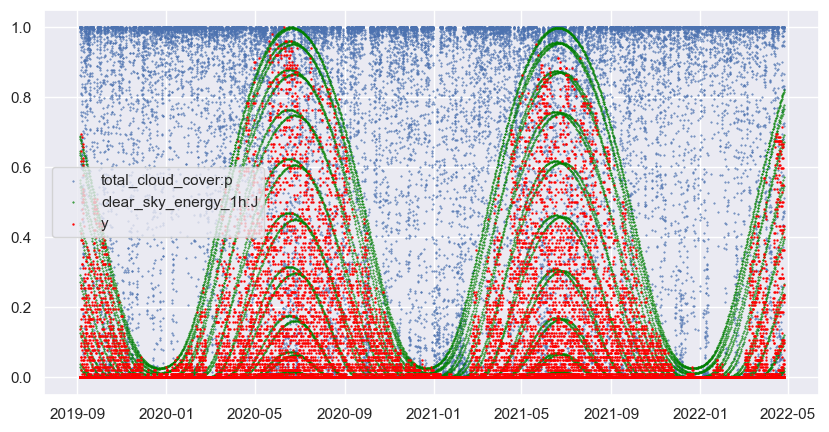

In [353]:
# EDA

train_normalized = (train - train.min()) / (train.max() - train.min())

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(train_normalized.index, train_normalized["total_cloud_cover:p"], s=0.2)
# plt.scatter(train_normalized.index, train_normalized["sun_elevation:d"], s=0.2)
plt.scatter(train_normalized.index, train_normalized["clear_sky_energy_1h:J"], s=0.2, c="green")
plt.scatter(train_normalized.index, train_normalized["y"], s=0.5, c="red")
ax.legend(["total_cloud_cover:p", "clear_sky_energy_1h:J", "y"])

print("Correlation Clear Sky Energy and y:")
print(np.corrcoef(train["clear_sky_energy_1h:J"], train["y"])[0][1])
print()
print("Correlation Cloud Cover and y:")
print(np.corrcoef(train["total_cloud_cover:p"], train["y"])[0][1])

In [354]:
# Clean up feature-set for test data

X_test = X_train_estimated.copy()
X_test = X_test.rename(columns={"date_forecast": "time"}).set_index("time").drop(columns=["date_calc"], errors="ignore")
X_test = X_test.resample('1H').mean().sort_index()
X_test.index = pd.to_datetime(X_test.index)

print("Shape:      ", X_test.shape)
print("Start:      ", X_test.index[0])
print("End:        ", X_test.index[-1])
print("Features:   ")
X_test.columns


Shape:       (4418, 45)
Start:       2022-10-28 22:00:00
End:         2023-04-30 23:00:00
Features:   


Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [355]:
# Clean up y for test data

y_test = train_a.copy()
y_test = y_test.rename(columns={"pv_measurement": "y"}).set_index("time")
y_test.index = pd.to_datetime(y_test.index)

print("Shape: ", y_test.shape)
print("Start: ", y_test.index[0])
print("End:   ", y_test.index[-1])

Shape:  (32155, 1)
Start:  2018-12-31 23:00:00
End:    2023-04-30 23:00:00


In [356]:
# Create test data

test = pd.merge(X_test, y_test, left_index=True, right_index=True, how="left")
test = test[test.y.notna()]
test = test[test["total_cloud_cover:p"].notna()]

Correlation Clear Sky Energy and y:
0.7994069240964947

Correlation Cloud Cover and y:
-0.18497820299016446


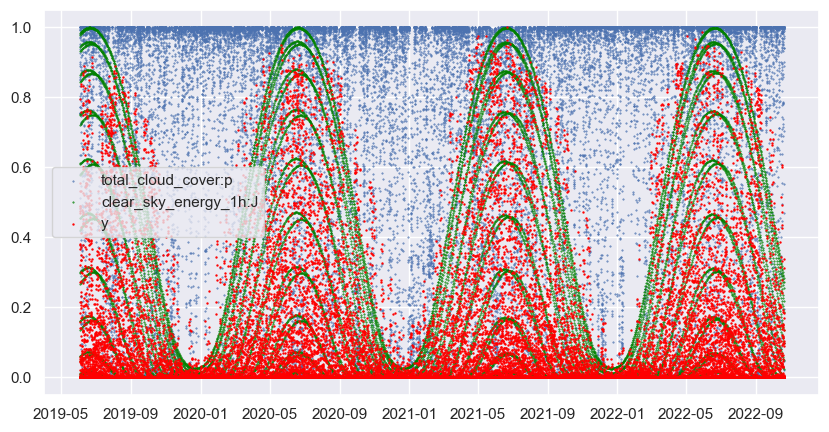

In [63]:
# EDA

test_normalized = (test - test.min()) / (test.max() - test.min())

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(test_normalized.index, test_normalized["total_cloud_cover:p"], s=0.2)
# plt.scatter(train_normalized.index, train_normalized["sun_elevation:d"], s=0.2)
plt.scatter(test_normalized.index, test_normalized["clear_sky_energy_1h:J"], s=0.2, c="green")
plt.scatter(test_normalized.index, test_normalized["y"], s=0.5, c="red")
ax.legend(["total_cloud_cover:p", "clear_sky_energy_1h:J", "y"])

print("Correlation Clear Sky Energy and y:")
print(np.corrcoef(test["clear_sky_energy_1h:J"], test["y"])[0][1])
print()
print("Correlation Cloud Cover and y:")
print(np.corrcoef(test["total_cloud_cover:p"], test["y"])[0][1])

array([[ 1.        , -0.43581218],
       [-0.43581218,  1.        ]])

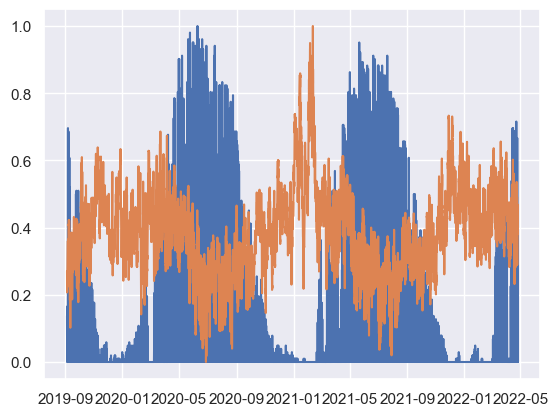

In [358]:
plot_data = train_normalized.copy()

plt.plot(plot_data.index, plot_data["y"])
plt.plot(plot_data.index, plot_data["air_density_2m:kgm3"])

np.corrcoef(plot_data["y"], plot_data["air_density_2m:kgm3"])

In [359]:
def create_time_feature(df):
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [360]:
train_time_features = create_time_feature(train.copy())
test_time_features = create_time_feature(test.copy())

In [361]:

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(train_time_features[[f for f in train_time_features.columns if f != "y"]],
        train_time_features[["y"]], verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

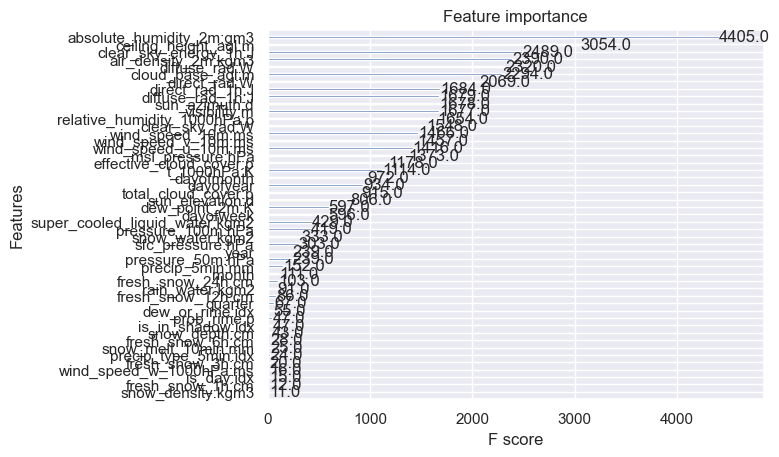

In [362]:
xgb.plot_importance(reg)

In [363]:
prediction = reg.predict(test_time_features[[f for f in test_time_features.columns if f != "y"]])

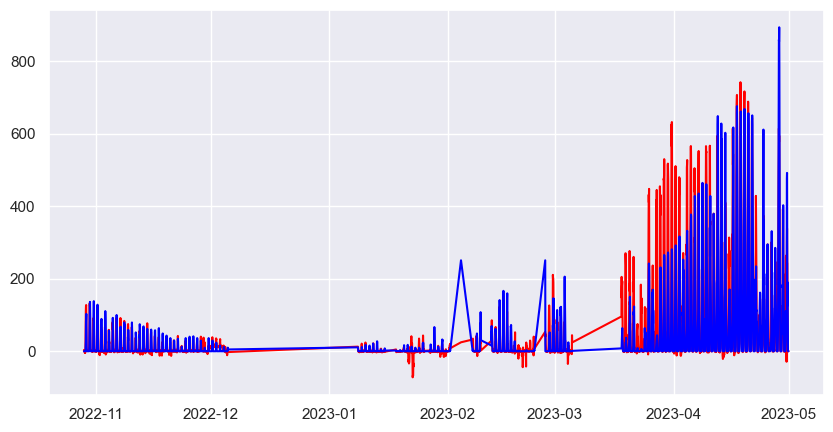

In [364]:
# test_normalized = (prediction - prediction.min()) / (prediction.max() - prediction.min())

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(test.index, prediction, c="red")
plt.plot(test.index, test["y"], c="blue")

In [365]:
from sklearn.metrics import mean_absolute_error

print('MAE: ', round(mean_absolute_error(y_true=test['y'],y_pred=prediction),3))

MAE:  24.298
